# 15-688 Final Project: Stock Prediction using Twitter Sentiment Analysis

## Table of Content
1. [Introduction and Problem Statement](#Introduction)
2. [Project Pipeline](#Project-Pipeline)
3. [Data Collection and Preprocessing](#Data-Collection-and-Preprocessing)
  - [Data Loading and Preprocessing](#Data-Loading-and-Preprocessing)
4. [Topic Modeling](#Topic-Modeling)
5. [Sentiment Analysis](#Sentiment-Analysis)
  - [TextBlob](#TextBlob)
  - [NLTK Vader](#NLTK-Vader)
6. [Twitter and Stock Data Preliminary Analysis](#Twitter-and-Stock-Data-Preliminary-Analysis)
  - [Tweets Data](#Tweets-Data)
  - [Stock Data](#Stock-Data)
7. [Model Training](#Model-Training)
8. [Conlusion](#Conclusion)
9. [Reference](#Reference)
10. [APPENDIX](#APPENDIX)
  - [Twitter Scraper](#Twitter-Scraper)
  - [yfinance API](#yfinance-API)

In [1]:
!pip install textblob
!pip install nltk
!pip install xgboost
!pip install wordcloud
!pip install pyLDAvis==2.1.2

     |████████████████████████████████| 1.6MB 13.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=ba3ce347d68730dfa7fee7d87adf9f6674e35987057ca08aa09e3a4557cd4473
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [2]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import urllib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pyLDAvis.gensim
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import nltk # NLTK
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Introduction

All companies care about their stock prices. A company’s stock price reflects investor perception of its ability to earn and grow its profits in the future. There were several stock market crashes due to the outbreak of the Covid-19 disease. March 2020 saw one of the most dramatic stock market crashes in history. We all know that the price market of a company is keeping changing all the time and could be affected by many factors and the pandemic makes trend of stock prices even much more unpredictable nowadays.

At the same time, vaccines have been released all over the world, which are expected to prevent the spread of this pandemic effectively. Vaccine providers such as Pfizer and Moderna attract more and more attention from investors. With social media that rapidly booming in popularity, Twitter with its rich information in nature stands out for the potential to use it for mining the database for the stock prediction. This also combining with the sentiment analysis is used to predict the stock price movements. For instance, Tejas Mankar and other authors of [Can twitter posts predict stock behavior?: A study of stock market with twitter social emotion](https://ieeexplore.ieee.org/document/7529584) proved a strong correlation between social sentiment related to a company and its stock price trends both from previous research and their own study[1]. Hence, to provide insights for investors and traders and support them to make decisions, we are trying to answer the underlying question: **How would the public sentiments and the coverage of each type of vaccine affect the stock price of its provider?**

After the simple data exploration, we find that the Tweets released on the previous day does affect the stock prices of three vaccine providers on the next day. For this reason, this report focuses on using a sentiment analysis that can give score to each individual tweets, combing with the core of the prediction, XGBoost, to predict the moving direction of the stock price. We will be only interested in the data starting from 12/10/2020 to 04/28/2021, because it’s close to the date of the very first doses of COVID-19 vaccine that were given in the U.S.



# Project Pipeline


<img src="./workflow1.png" width=800 height=300> 


# Data Collection and Preprocessing

For the purpose of this project, we are mainly interested in two types of data source: **tweets text** and **market (stock) data**

We used two APIs for data collection:

- [Twitter](https://developer.twitter.com/en/docs/twitter-api): This API returns returns a collection of relevant tweets which matches a specified query

- [yfinance API](https://pypi.org/project/yfinance/): This API returns historical stock price data for three vaccine providers by a ‘ticker’, the stock symbol, which is a nickname for a particular company.

Raw tweets and stock price for vaccine providers have been collected and saved as files. The report will start from loading these files for further analysis. If you want know more about data collecting, codes have been appended at the APPENDIX section of the report. 

## Data Loading and Preprocessing

We did some data cleaning on the raw tweets text, including handling case and punctuation, and tokenizing raw texts. We also assign the related company's name to each tweet for the purpose of sentiment analysis

In [3]:
tweet_df_raw = pd.read_csv('./combined_raw_tweets.csv', encoding = 'iso8859',index_col=False)

stock_jnj = pd.read_csv('./jnj.csv')
stock_moderna = pd.read_csv('./moderna.csv')
stock_pfizer = pd.read_csv('./pfizer.csv')

#import tweets and stock information from 04/29/2021 to 05/11/2021 as validation set
tweet_val_raw = pd.read_csv('./validation_raw_tweets.csv')
stock_val_pfizer = pd.read_csv('./val_pfizer.csv')
stock_val_moderna = pd.read_csv('./val_moderna.csv')
stock_val_jnj = pd.read_csv('./val_jnj.csv')


#concatenate training set and validation set
stock_pfizer = pd.concat([stock_pfizer, stock_val_pfizer])
stock_moderna = pd.concat([stock_moderna, stock_val_moderna])
stock_jnj = pd.concat([stock_jnj, stock_val_jnj])

#tweet_df = tweet_df_raw.drop(columns = ['Unnamed: 0'])
#tweet_val_df = tweet_df_raw.drop(columns = ['Unnamed: 0'])
tweet_df = tweet_df_raw[['text','created_at']]
tweet_val_df = tweet_val_raw[['text','created_at']]

In [4]:
def data_preprocess(text):
    """ Handle case and punctuation, and tokenize raw texts
    
    args:
        text: str -- raw text

    Outputs:
        list(str): tokenized text
    """
   #Convert the text to lower case.
    text = text.lower()  
    #remove trailing ''s'
    text =text.replace("'s", "")
    #omit other apostrophes
    text=text.replace("'","")
    #omit other apostrophes
    text=text.replace("amp","")
    #Remove any URLs
    text = re.sub('http[s]?://t.co/[a-zA-Z0-9]+', '', text)
    #Remove all non-alphanumeric
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)

    return text

In [5]:
def cleaning(tweet_df):
    # Drop duplicates (if any)
    tweet_df.drop_duplicates(inplace = True)
    tweet_df['created_at'] = tweet_df['created_at'].astype(str).apply(lambda x: x[:10])
    tweet_df.reset_index(drop = True)

    #remove the original text column
    tweet_df = tweet_df.drop(columns = ['text'])
    #filter out any tweets with incomplete date, for which we consider the information is not captured right
    filter = tweet_df[tweet_df['created_at'].str.len()<9]
    tweet_df.drop(filter.index, inplace = True)

    #assign each company's name as keyword for every tweet
    tweet_df['keyword'] = None
    hashtags = ['pfizer', 'moderna','johnsonandjohnson','jnj','pfizervaccine','biontech','mrna']
    for hashtag in hashtags:
        for idx,text in enumerate(tweet_df['text_clean']):
            if hashtag in text:
                tweet_df['keyword'].iloc[idx] = hashtag
    for idx,keyword in enumerate(tweet_df['keyword']):
        if keyword in ['moderna','mrna']:
            tweet_df['keyword'].iloc[idx] = 'moderna'
        if keyword in ['pfizer','pfizervaccine','biontech']:
            tweet_df['keyword'].iloc[idx]= 'pfizer'
        if keyword in ['johnsonandjohnson','jnj']:
            tweet_df['keyword'].iloc[idx] = 'johnsonandjohnson'
    return tweet_df


In [6]:
#pre-process and clean the raw tweet text
tweet_df['text_clean'] = tweet_df['text'].astype(str).apply(lambda x: data_preprocess(x))
tweet_val_df['text_clean'] = tweet_val_df['text'].astype(str).apply(lambda x: data_preprocess(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
tweet_df = cleaning(tweet_df)
tweet_val_df = cleaning(tweet_val_df) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [8]:
print(tweet_df['keyword'].value_counts())

print("Number of original tweets we scraped: ", len(tweet_df_raw))
print("Number of tweets after cleaning and dropping duplications: ", len(tweet_df))

pfizer               88027
moderna              42846
johnsonandjohnson    17099
Name: keyword, dtype: int64
Number of original tweets we scraped:  1479960
Number of tweets after cleaning and dropping duplications:  147975


After we dropped duplications and filtered out meaningless tweets, the cleaned data contains 147,975 tweets in total. As the above distribution shows, the number of tweets related to moderna and johnson&johnson are much smaller than the ones related to pfizer, which might be caused by the availability and popularity of each vaccine. However, since our further analysis and modeling target the three providers separately, this imbalance will not affect our results too much.

# Topic Modeling

Topic Modeling is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents. Latent Dirichlet Allocation (LDA) is an example of topic model and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions. Here we are going to apply LDA to the tweets data and split them into topics so that we could get some insights about what people concern about Covid-19 Vaccines and their providers.

In [9]:
# Group cleaned tweet_df by companies
pfizer_df = tweet_df[tweet_df.keyword=='pfizer']
moderna_df = tweet_df[tweet_df.keyword == 'moderna']
jnj_df = tweet_df[tweet_df.keyword == 'johnsonandjohnson']
biontech_df = tweet_df[tweet_df.keyword == 'biontech']

In [10]:
# Define a method to conduct LDA analysis
def lda_report(df, vocab_size=2000, num_topics=8,num_top_words=20):
  X=df['text_clean'].values

  # add stopwords
  stop_words = (set(stopwords.words('english')))
  remove_words = ['vaccine', 'covid19','coronavirus', 'covid', 'covidvaccine', 'vaccines','covid19vaccine','pfizer','biontech','mrna','johnsonandjohnson','pfizervaccine','moderna','johnson']
  stop_words = remove_words + list(stop_words)



  vectorizer = CountVectorizer(max_df=0.95,
                                min_df=2,
                                stop_words=stop_words,
                                max_features=vocab_size)
  tf = vectorizer.fit_transform(X)
  lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
  lda.fit(tf)
  topic_word_distributions = np.array([row / row.sum() for row in lda.components_])

  vocab = vectorizer.get_feature_names()
  num_topics = len(topic_word_distributions)
  print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
  print()
  
  # print out the result
  for topic_idx in range(num_topics):
      print('[Topic ', topic_idx, ']', sep='')
      sort_indices = np.argsort(-topic_word_distributions[topic_idx])
      for rank in range(num_top_words):
          word_idx = sort_indices[rank]
          print(vocab[word_idx], ':',
                topic_word_distributions[topic_idx, word_idx])
      print()


Then, we could conduct the LDA analysis on the dataframe we are interested in by calling lda_report method we defined so figure out some main topics included in data. Here we will take Johnson & Johnson tweets data (jnj_df) as an example. Welcome to comment out the method calling on other data.

In [11]:
lda_report(jnj_df)
#lda_report(moderna_df)
#lda_report(pfizer_df)
#lda_report(biontech_df)
#lda_report(tweet_df)

Displaying the top 20 words per topic and their probabilities within the topic...

[Topic 0]
got : 0.03878904738243857
one : 0.03693237856853898
shot : 0.030321127472618288
vaccinated : 0.02718991508389437
done : 0.024205543341929675
get : 0.02311840271582027
today : 0.0216063749782501
thank : 0.011323702378919519
vaccination : 0.01009588534555345
severe : 0.009558170064490465
oneanddone : 0.009340381926451998
getvaccinated : 0.009114676059646715
think : 0.007591453950563042
effective : 0.007548424324986624
appointment : 0.007547694094279563
available : 0.006986330753068472
please : 0.006046298970991171
johnsonandjohnsonvaccine : 0.00599248693842272
covidvacccine : 0.005771008468921636
appointments : 0.005755642925749691

[Topic 1]
19 : 0.042243344344249055
vaccinated : 0.04174777657591694
dr : 0.02432766846698994
dose : 0.023879796773042358
astrazeneca : 0.01939569271301967
hospital : 0.0183882419467069
single : 0.017013917226296985
taking : 0.016679831423732416
safe : 0.0164154063647

The LDA analysis does provide us some meaningful information about these companies from twetter texts. From the result we gained, we can tell that, for Johnson & Johnson, many people concern about blood clots [Topic #4] and side effects [Topic #5]. To dig out more information hidden in the text, we will then conduct sentiment analysis and explorday data analysis next.

# Sentiment Analysis

With the full content of tweets, after we compared TextBlob and NLTK Vader, which are popular Python libraries for processing textual data, we finally decided to use NLTK Vader, which offers a more balanced sentiment results. We took the polarity score (a float within the range [-1.0, 1.0] with a neutral threshold=0.5, representing negative -> neutral -> positive) from the analysis result as a new feature called 'sentiment'.

In [12]:
# Define a function to show the summary of sentiment results 
def sentiment_summary(data, col):
    count = pd.DataFrame(data[col].value_counts())
    percentage = pd.DataFrame(data[col].value_counts(normalize=True).mul(100))
    counts_df = pd.concat([count, percentage], axis = 1).reset_index()
    counts_df.columns = ['Sentiment', 'Counts', 'Percentage']
    counts_df.sort_values('Sentiment', inplace = True)
    counts_df['Percentage'] = counts_df['Percentage'].apply(lambda x: round(x,2))
    counts_df  = counts_df.reset_index(drop = True)
    return counts_df

## TextBlob

TextBlob is used to process textual data and perform NLP tasks including sentiment analysis. The classifier is using a bag of words approach.

In [13]:
neutral_thresh = 0.05
tweet_df['textblob_score'] = tweet_df['text_clean'].apply(lambda x: TextBlob(x).sentiment.polarity)
tweet_val_df['textblob_score'] = tweet_val_df['text_clean'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Convert polarity score into sentiment categories
tweet_df['textblob_sentiment'] = tweet_df['textblob_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))
tweet_val_df['textblob_sentiment'] = tweet_val_df['textblob_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))
textblob_sentiment = sentiment_summary(tweet_df,'textblob_sentiment')
textblob_sentiment['Techniques'] = 'TextBlob'
textblob_sentiment

,Sentiment,Counts,Percentage,Techniques
0,Negative,19127,12.93,TextBlob
1,Neutral,60207,40.69,TextBlob
2,Positive,68641,46.39,TextBlob


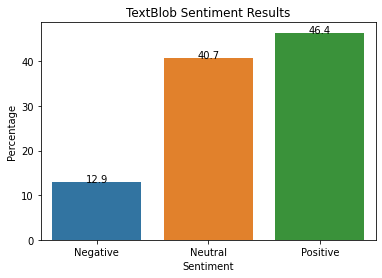

In [14]:
ax = sns.barplot(x="Sentiment", y="Percentage", data=textblob_sentiment)
ax.set_title('TextBlob Sentiment Results')

for index, row in textblob_sentiment.iterrows():
    ax.text(row.name,row.Percentage, round(row.Percentage,1), color='black', ha="center")

## NLTK Vader

Natural Learning Toolkit (NLTK) provides programs, which support natural language processing (NLP). Particularly, we will be using the Valence Aware Dictionary and sEntiment Reasoner (VADER) model, a lexicon and rule-based sentiment analysis tool specifically focusing on sentiment analysis of social media text. Similar to TextBolb, it also leverages a bag of words approach with simple heuristics. For example, it increases the sentiment intensity in presence of certain vocabularies, such as "pretty" or "very".

In [15]:
sia = SentimentIntensityAnalyzer()

# Get NLTK scores
tweet_df['nltk_scores'] = tweet_df['text_clean'].apply(lambda x: sia.polarity_scores(x))
tweet_val_df['nltk_scores'] = tweet_val_df['text_clean'].apply(lambda x: sia.polarity_scores(x))

# Get NLTK compound score
tweet_df['nltk_cmp_score'] = tweet_df['nltk_scores'].apply(lambda score_dict: score_dict['compound'])
tweet_val_df['nltk_cmp_score'] = tweet_val_df['nltk_scores'].apply(lambda score_dict: score_dict['compound'])

In [16]:
neutral_thresh = 0.05

# Categorize scores into the sentiments of positive, neutral or negative
tweet_df['nltk_sentiment'] = tweet_df['nltk_cmp_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))
tweet_val_df['nltk_sentiment'] = tweet_val_df['nltk_cmp_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))


nltk_sentiment_df = sentiment_summary(tweet_df,'nltk_sentiment')
nltk_sentiment_df['Techniques'] = 'NLTK Vader'
nltk_sentiment_df

,Sentiment,Counts,Percentage,Techniques
0,Negative,35975,24.31,NLTK Vader
1,Neutral,46680,31.55,NLTK Vader
2,Positive,65320,44.14,NLTK Vader


In [17]:
tweet_df.head()

,created_at,text_clean,keyword,textblob_score,textblob_sentiment,nltk_scores,nltk_cmp_score,nltk_sentiment
0,2021-04-28,the weather for day 2 pfizervaccine clinic w...,pfizer,0.575000,Positive,"{'neg': 0.0, 'neu': 0.871, 'pos': 0.129, 'comp...",0.6369,Positive
1,2021-04-28,here is some information on where to get your ...,pfizer,0.400000,Positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
2,2021-04-28,prayers for daniel and his family ...,pfizer,-0.166667,Negative,"{'neg': 0.134, 'neu': 0.866, 'pos': 0.0, 'comp...",-0.4767,Negative
3,2021-04-28,got vax 1 today whoah my arm ...,pfizer,0.100000,Positive,"{'neg': 0.104, 'neu': 0.718, 'pos': 0.178, 'co...",0.3080,Positive
4,2021-04-28,officially vaccinated covidvaccine getvacc...,pfizer,0.000000,Neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral


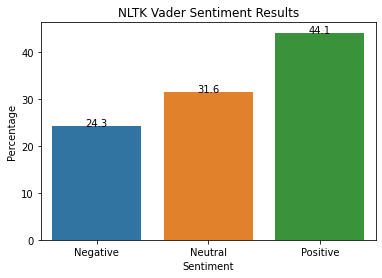

In [18]:
ax = sns.barplot(x="Sentiment", y="Percentage", data=nltk_sentiment_df)
ax.set_title('NLTK Vader Sentiment Results')

for index, row in nltk_sentiment_df.iterrows():
    ax.text(row.name,row.Percentage, round(row.Percentage,1), color='black', ha="center")

In [19]:
sentiments = pd.concat([nltk_sentiment_df, 
                           textblob_sentiment, 
                          ]).reset_index(drop=True)
sentiments

,Sentiment,Counts,Percentage,Techniques
0,Negative,35975,24.31,NLTK Vader
1,Neutral,46680,31.55,NLTK Vader
2,Positive,65320,44.14,NLTK Vader
3,Negative,19127,12.93,TextBlob
4,Neutral,60207,40.69,TextBlob
5,Positive,68641,46.39,TextBlob


In [20]:
sentiments_pivot = sentiments.pivot(index='Sentiment', columns = 'Techniques',values='Percentage')
sentiments_pivot

Techniques,NLTK Vader,TextBlob
Sentiment,,
Negative,24.31,12.93
Neutral,31.55,40.69
Positive,44.14,46.39


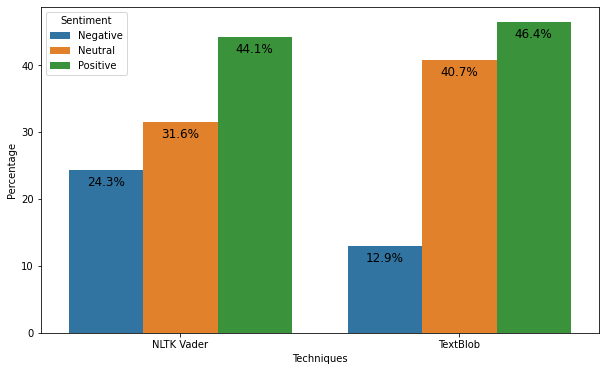

In [21]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Techniques", y="Percentage",
                 hue="Sentiment", data=sentiments)

# Display annotations
for p in ax.patches:
    ax.annotate(f"{round(p.get_height(),1)}%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=12,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

Because NLTK Vader gives more balanced result than TextBlob, we will be using the sentiment scores generated by NLTK Vader for the further analysis.

# Twitter and Stock Data Preliminary Analysis

Let's conduct preliminary analysis through EDA for tweets and stock price movements to gain a better understanding of their possible correlation.

## **Tweets Data**

In addition to default stopwords, we also removed some common words related to Covid-19 and meaningless words.

In [22]:
def word_cloud(data, sentiment):
    stop_words = (set(stopwords.words('english')))
    remove_words = ['vaccine', 'covid19','coronavirus', 'covid', 'covidvaccine', 'vaccines','covid19vaccine','amp',  '2','19','get','got','1','today','vaccination','first','second','2nd','dose','doses','one','received','j','6']
    stop_words = remove_words + list(stop_words)
    plt.figure(figsize=[15,15])
    clean_tweets= "".join(list(data[data['nltk_sentiment']==sentiment]['text_clean'].values))
    wordcloud = WordCloud(width=700,height=400, background_color='white',colormap='plasma', max_words=50, stopwords=stop_words, collocations=False).generate(clean_tweets)
    plt.title(f"Top 50 {sentiment} words used in tweets", fontsize=20)
    plt.imshow(wordcloud)
    return plt.show()

### Top 50 words for all tweets

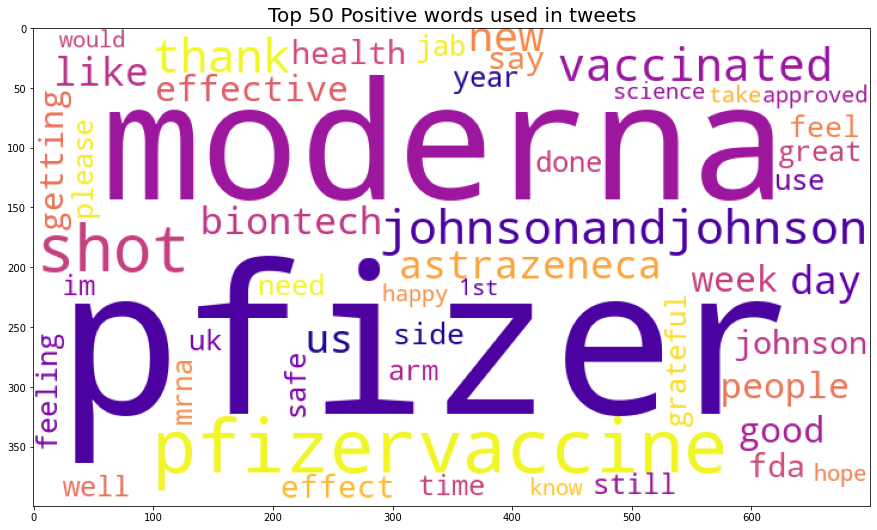

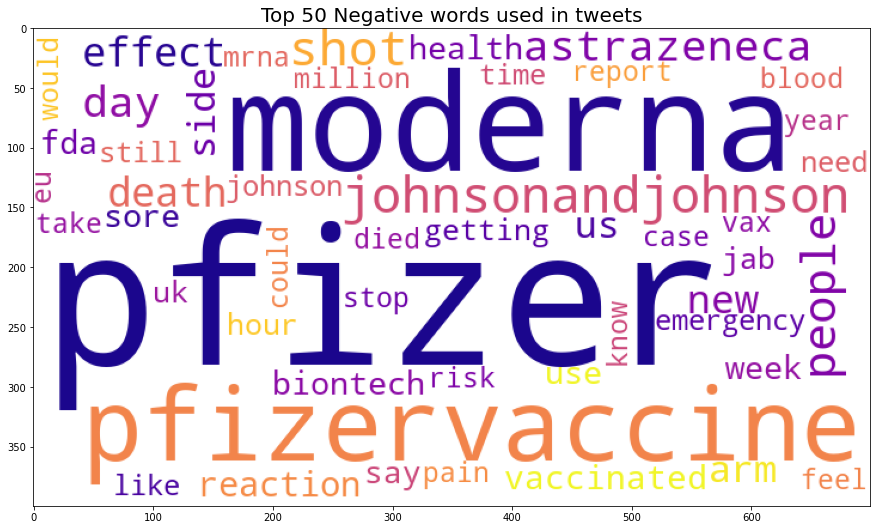

In [23]:
word_cloud(tweet_df,sentiment='Positive')
word_cloud(tweet_df,sentiment='Negative')

As we can observe from the WordClouds for positive tweets and negative tweets, 'Pfizer' and 'Moderna' appears more frequently in positive tweets, whereas 'Johnson&Johnson' occurs in negative tweets more often, which corresponds to the quick spread of its bad news

### Top 10 words for each company and wordcloud

Since companies' name are definitely the words that occur the most often in corresponding tweets, then we removed them from the tweets.

In [24]:
pfizer_df = tweet_df[tweet_df['keyword']=='pfizer']
moderna_df = tweet_df[tweet_df['keyword']=='moderna']
jnj_df = tweet_df[tweet_df['keyword']=='johnsonandjohnson']

In [25]:
pos_df = tweet_df[tweet_df['nltk_sentiment']=='Positive']
neg_df = tweet_df[tweet_df['nltk_sentiment']=='Negative']

pos_list = []
neg_list = []
for text in pos_df['text_clean']:
  for word in text.split():
    pos_list.append(word)
for text in neg_df['text_clean']:
  for word in text.split():
    neg_list.append(word)

In [26]:
from nltk.corpus import stopwords 
stop_words = set(stopwords.words("english"))
filtered_pos_list = [word for word in pos_list if not word in stop_words ]
filtered_neg_list = [word for word in neg_list if not word in stop_words ]

In [27]:
from collections import Counter
#create a dictionary with word counts so we can quantify the most common words
pos_dict = Counter(filtered_pos_list)
neg_dict = Counter(filtered_neg_list)

#sort the word counts in descending order
pos_dict_sorted = dict(sorted(pos_dict.items(), key=lambda item: item[1], reverse=True))
neg_dict_sorted = dict(sorted(neg_dict.items(), key=lambda item: item[1], reverse=True))

#create dataframes of words counts for each type of tweet
pos_text_df = pd.DataFrame.from_dict(pos_dict_sorted, orient='index', columns=['Count'])
pos_text_df.reset_index(inplace=True)
pos_text_df.rename(columns={'index':'Word'}, inplace=True)

neg_text_df = pd.DataFrame.from_dict(neg_dict_sorted, orient='index', columns=['Count'])
neg_text_df.reset_index(inplace=True)
neg_text_df.rename(columns={'index':'Word'}, inplace=True)

In [28]:
def top_10_company(company):
  pos_df_com = pos_df[pos_df['keyword']==company]
  neg_df_com = neg_df[neg_df['keyword']==company]

  pos_list = []
  neg_list = []
  for text in pos_df_com['text_clean']:
    for word in text.split():
      pos_list.append(word)
  for text in neg_df_com['text_clean']:
    for word in text.split():
      neg_list.append(word)

  stop_words = set(stopwords.words("english"))
  remove_words = ['vaccine', 'covid19','shot','coronavirus', 'covid', 'covidvaccine', 'vaccines','covid19vaccine','pfizer','biontech','mrna','johnsonandjohnson','pfizervaccine','moderna','johnson',\
                 'astrazeneca', '2','19','get','got','1','today','vaccination','first','second','2nd','dose','doses','one','received','j','6']
  stop_words = remove_words + list(stop_words)
  filtered_pos_list = [word for word in pos_list if not word in stop_words ]
  filtered_neg_list = [word for word in neg_list if not word in stop_words ]
  #create a dictionary with word counts so we can quantify the most common words
  pos_dict = Counter(filtered_pos_list)
  neg_dict = Counter(filtered_neg_list)

  #sort the word counts in descending order
  pos_dict_sorted = dict(sorted(pos_dict.items(), key=lambda item: item[1], reverse=True))
  neg_dict_sorted = dict(sorted(neg_dict.items(), key=lambda item: item[1], reverse=True))

  #create dataframes of words counts for each type of tweet
  pos_text_df = pd.DataFrame.from_dict(pos_dict_sorted, orient='index', columns=['Count'])
  pos_text_df.reset_index(inplace=True)
  pos_text_df.rename(columns={'index':'Word'}, inplace=True)

  neg_text_df = pd.DataFrame.from_dict(neg_dict_sorted, orient='index', columns=['Count'])
  neg_text_df.reset_index(inplace=True)
  neg_text_df.rename(columns={'index':'Word'}, inplace=True)
  
  return pos_text_df, neg_text_df

In [29]:
def get_word_cloud_company(data, sentiment):
    stop_words = (set(stopwords.words('english')))
    remove_words =  ['vaccine', 'covid19','shot','coronavirus', 'covid', 'covidvaccine', 'vaccines','covid19vaccine','pfizer','biontech','mrna','johnsonandjohnson','pfizervaccine','moderna','johnson',\
                 'astrazeneca', '2','19','get','got','1','today','vaccination','first','second','2nd','dose','doses','one','received','j','6']
    stop_words = remove_words + list(stop_words)
    plt.figure(figsize=[15,15])
    clean_tweets= "".join(list(data[data['nltk_sentiment']==sentiment]['text_clean'].values))
    wordcloud = WordCloud(width=700,height=400, background_color='white',colormap='plasma', max_words=50, stopwords=stop_words, collocations=False).generate(clean_tweets)
    plt.title(f"Top 50 {sentiment} words used in tweets", fontsize=20)
    plt.imshow(wordcloud)
    return plt.show()

#### Pfizer

In [30]:
pos_text_df_pfizer, neg_text_df_pfizer = top_10_company('pfizer')

[Text(0, 0, 'people'),
 Text(0, 0, 'side'),
 Text(0, 0, 'effects'),
 Text(0, 0, 'arm'),
 Text(0, 0, 'us'),
 Text(0, 0, 'uk'),
 Text(0, 0, 'vaccinated'),
 Text(0, 0, 'health'),
 Text(0, 0, 'death'),
 Text(0, 0, 'news')]

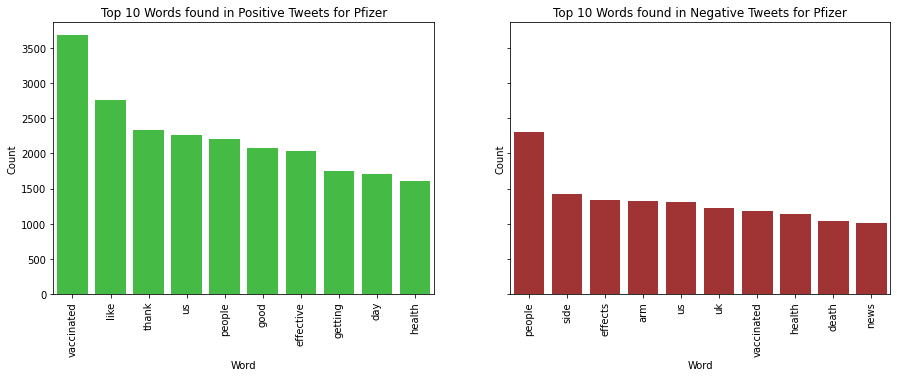

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
p = sns.barplot(ax=axes[0],x=pos_text_df_pfizer['Word'][:10], y=pos_text_df_pfizer['Count'][:10], data=pos_text_df_pfizer[:10], color='limegreen')
axes[0].set_title('Top 10 Words found in Positive Tweets for Pfizer')
p.set_xticklabels(p.get_xticklabels(),rotation=90)
n= sns.barplot(ax=axes[1],x=neg_text_df_pfizer['Word'][:10], y=neg_text_df_pfizer['Count'][:10], data=neg_text_df_pfizer[:10], color='firebrick')
axes[1].set_title('Top 10 Words found in Negative Tweets for Pfizer')
n.set_xticklabels(n.get_xticklabels(),rotation=90)

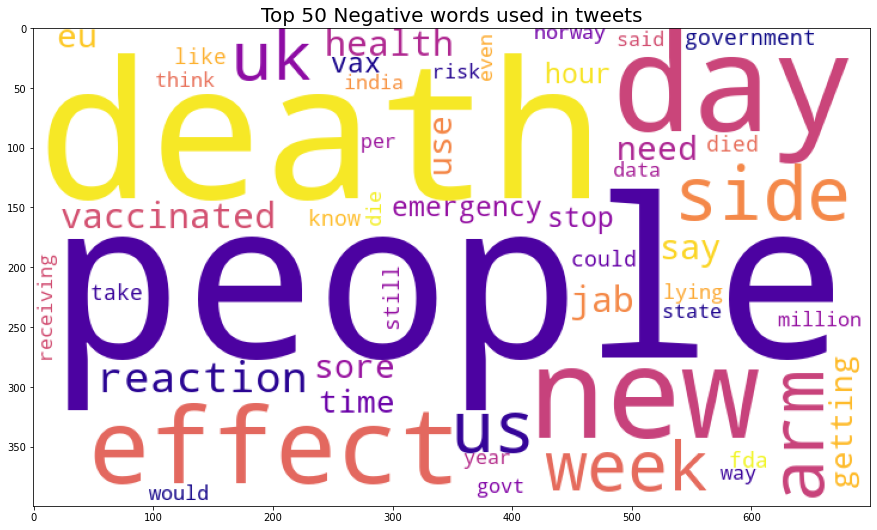

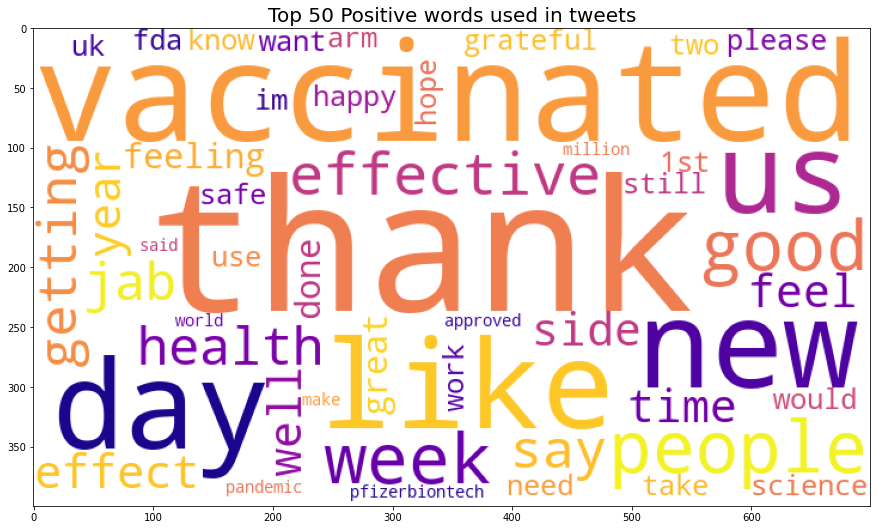

In [32]:
get_word_cloud_company(pfizer_df,sentiment='Negative')
get_word_cloud_company(pfizer_df,sentiment='Positive')

#### Moderna

In [33]:
pos_text_df_moderna, neg_text_df_moderna = top_10_company('moderna')

[Text(0, 0, 'arm'),
 Text(0, 0, 'side'),
 Text(0, 0, 'people'),
 Text(0, 0, 'effects'),
 Text(0, 0, 'sore'),
 Text(0, 0, 'vaccinated'),
 Text(0, 0, 'day'),
 Text(0, 0, 'us'),
 Text(0, 0, 'hours'),
 Text(0, 0, 'days')]

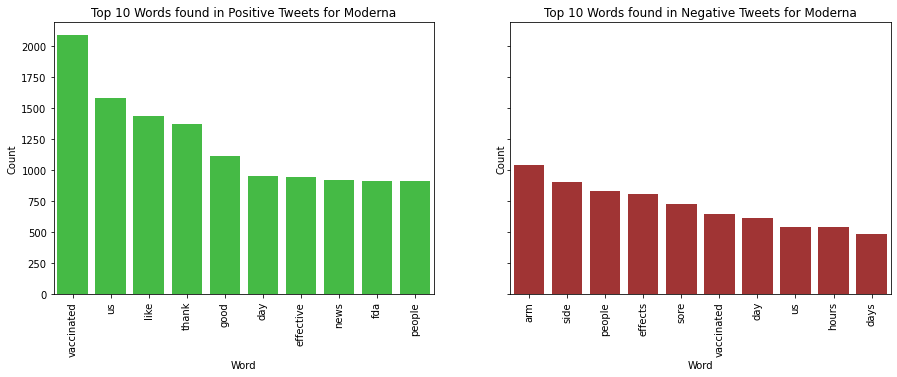

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
p = sns.barplot(ax=axes[0],x=pos_text_df_moderna['Word'][:10], y=pos_text_df_moderna['Count'][:10], data=pos_text_df_moderna[:10], color='limegreen')
axes[0].set_title('Top 10 Words found in Positive Tweets for Moderna')
p.set_xticklabels(p.get_xticklabels(),rotation=90)
n= sns.barplot(ax=axes[1],x=neg_text_df_moderna['Word'][:10], y=neg_text_df_moderna['Count'][:10], data=neg_text_df_moderna[:10], color='firebrick')
axes[1].set_title('Top 10 Words found in Negative Tweets for Moderna')
n.set_xticklabels(n.get_xticklabels(),rotation=90)

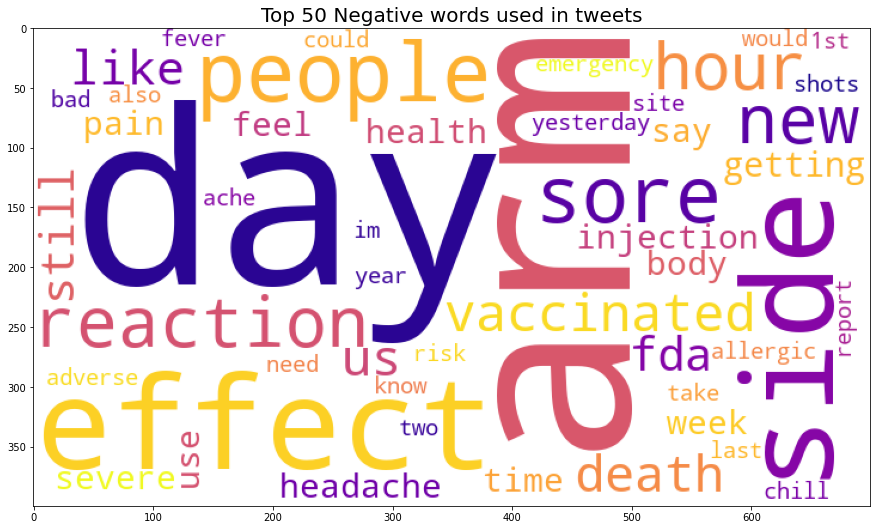

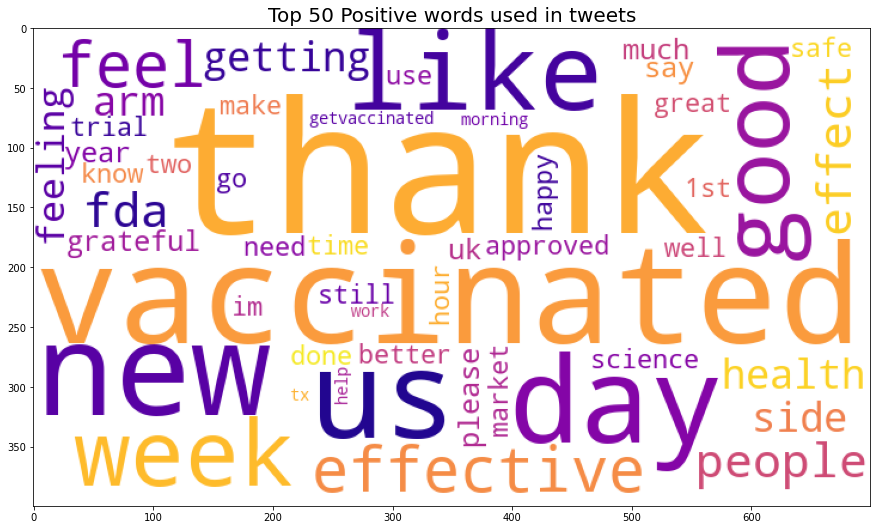

In [35]:
get_word_cloud_company(moderna_df,sentiment='Negative')
get_word_cloud_company(moderna_df,sentiment='Positive')

#### J&J

In [36]:
pos_text_df_jnj, neg_text_df_jnj = top_10_company('johnsonandjohnson')

[Text(0, 0, 'blood'),
 Text(0, 0, 'people'),
 Text(0, 0, 'fda'),
 Text(0, 0, 'us'),
 Text(0, 0, 'clots'),
 Text(0, 0, 'use'),
 Text(0, 0, 'million'),
 Text(0, 0, 'pause'),
 Text(0, 0, 'cdc'),
 Text(0, 0, 'cases')]

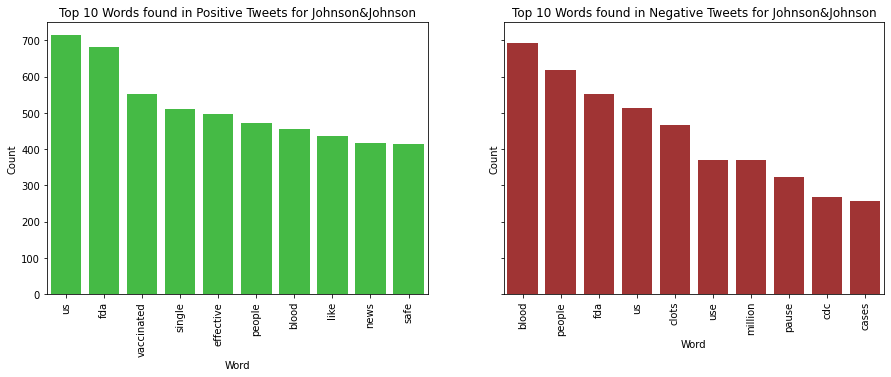

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
p = sns.barplot(ax=axes[0],x=pos_text_df_jnj['Word'][:10], y=pos_text_df_jnj['Count'][:10], data=pos_text_df_jnj[:10], color='limegreen')
axes[0].set_title('Top 10 Words found in Positive Tweets for Johnson&Johnson')
p.set_xticklabels(p.get_xticklabels(),rotation=90)
n= sns.barplot(ax=axes[1],x=neg_text_df_jnj['Word'][:10], y=neg_text_df_jnj['Count'][:10], data=neg_text_df_jnj[:10], color='firebrick')
axes[1].set_title('Top 10 Words found in Negative Tweets for Johnson&Johnson')
n.set_xticklabels(n.get_xticklabels(),rotation=90)

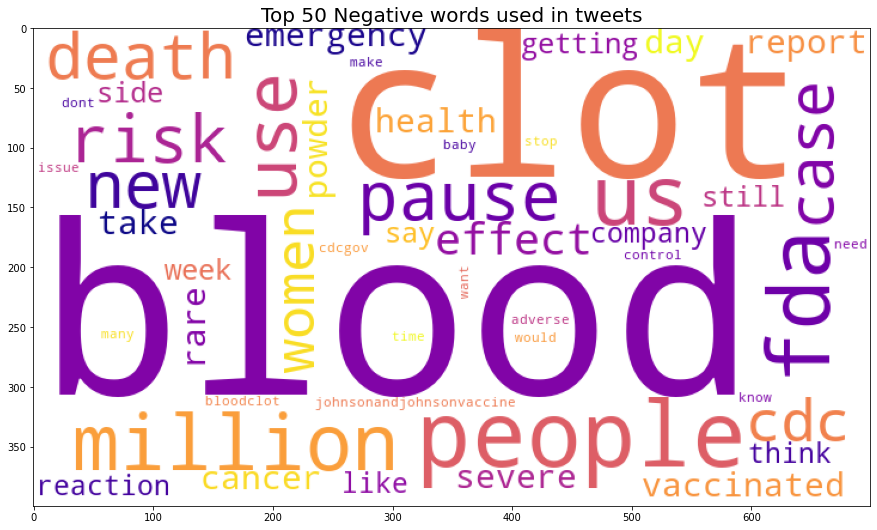

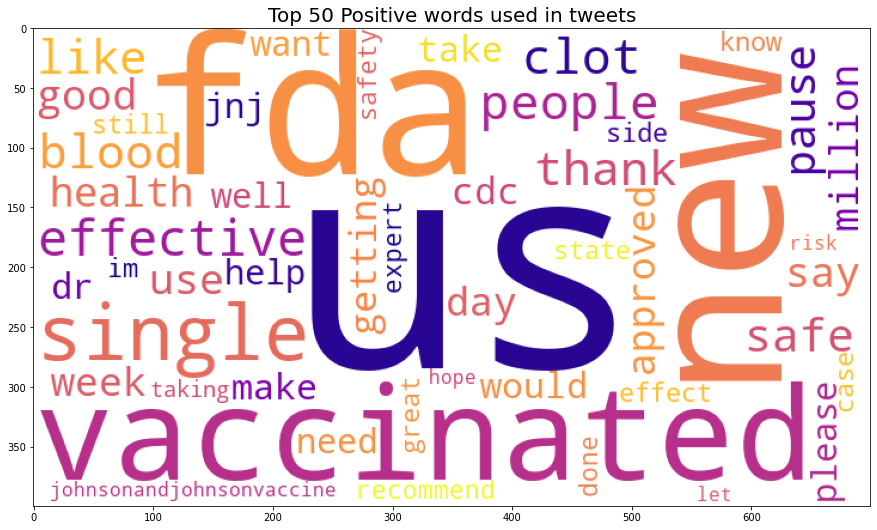

In [38]:
get_word_cloud_company(jnj_df,sentiment='Negative')
get_word_cloud_company(jnj_df,sentiment='Positive')

**Pfizer** : vaccinated,like, thank,effective,side effects, arm, sore

**Moderna**: vaccinated, like, thank, effective, arm, sore, side effects

**Johnson&Johnson**: us, fda, vaccinated, like, blood, clots, pause, cdc

Top words for respective companies reflect what the public's interests fall in is somehow similar. For instance, 'arm sore' and 'side effects' are the most common words appear in all three companies' tweets. Meanwhile, comparing to the other two companies, Johnson&Johnson is strongly correlated to blood clots issues. 

## Stock Data

In [39]:
tweet_df = pd.concat([tweet_df, tweet_val_df])
tweet_df 

,created_at,text_clean,keyword,textblob_score,textblob_sentiment,nltk_scores,nltk_cmp_score,nltk_sentiment
0,2021-04-28,the weather for day 2 pfizervaccine clinic w...,pfizer,0.575000,Positive,"{'neg': 0.0, 'neu': 0.871, 'pos': 0.129, 'comp...",0.6369,Positive
1,2021-04-28,here is some information on where to get your ...,pfizer,0.400000,Positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
2,2021-04-28,prayers for daniel and his family ...,pfizer,-0.166667,Negative,"{'neg': 0.134, 'neu': 0.866, 'pos': 0.0, 'comp...",-0.4767,Negative
3,2021-04-28,got vax 1 today whoah my arm ...,pfizer,0.100000,Positive,"{'neg': 0.104, 'neu': 0.718, 'pos': 0.178, 'co...",0.3080,Positive
4,2021-04-28,officially vaccinated covidvaccine getvacc...,pfizer,0.000000,Neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
...,...,...,...,...,...,...,...,...
19442,2021-04-29,uchealth is already planning for covid 19 vac...,pfizer,0.000000,Neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
19443,2021-04-29,i am so happy to be fullycovid19vaccinated ...,moderna,0.800000,Positive,"{'neg': 0.0, 'neu': 0.6, 'pos': 0.4, 'compound...",0.6115,Positive
19444,2021-04-29,1 covid 19 uk secures 60 millio ove...,pfizer,0.000000,Neutral,"{'neg': 0.0, 'neu': 0.685, 'pos': 0.315, 'comp...",0.5574,Positive
19445,2021-04-29,round 1 now go get yours cov...,moderna,-0.200000,Negative,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral


In [40]:
def combine_df(tweet_df, stock_df, tweet_keyword, stock_col):
    #[1,10,13,16]
  tweet_filtered = tweet_df[tweet_df['keyword'] == tweet_keyword]
  tweet_filtered['created_at'] = pd.to_datetime(tweet_filtered['created_at'])
  
  date_dic = {}
  for i in range(len(tweet_filtered)):
    row = tweet_filtered.iloc[i]
    date = row['created_at']
    if (date.dayofweek == 5):
      date = date - pd.Timedelta(days=1)
    if (date.dayofweek == 6):
      date = date - pd.Timedelta(days=2)
    text = row['text_clean']
    score = row['nltk_cmp_score']
    sentiment = row['nltk_sentiment']
    
    if sentiment == "Neutral":
      if date not in date_dic.keys():
        date_dic[date] = [[], [], [sentiment]]
      else:
        date_dic[date][2].append(sentiment)
    
    else:
      if date not in date_dic.keys():
        date_dic[date] = [[text], [score], [sentiment]]
      else:
        date_dic[date][0].append(text)
        date_dic[date][1].append(score)
        date_dic[date][2].append(sentiment)
    
  date_score_dic = {}
  date_text_dic = {}
  date_sent_dic = {}
  for key, value in date_dic.items():
    date_score_dic[key] = np.mean(value[1])
    date_text_dic[key] = ' '.join(value[0])
    date_sent_dic[key] = [sum(np.array(value[2]) == "Negative"), sum(np.array(value[2]) == "Positive"), sum(np.array(value[2]) == "Neutral")]
  
  tweet_df_combined_score = pd.DataFrame(date_score_dic.items(), columns=['Date', 'Score'])
  tweet_df_combined_text = pd.DataFrame(date_text_dic.items(), columns=['Date', 'Text'])
  tweet_df_combined_sent = pd.DataFrame.from_dict(date_sent_dic, orient = 'index', columns=['Negative', 'Positive', 'Neutral'])
  tweet_df_combined_sent.reset_index(inplace=True)
  tweet_df_combined_sent.columns = ['Date', 'Negative', 'Positive', 'Neutral']
  tweet_df_combined_sent['Total Tweets'] = tweet_df_combined_sent['Positive'] + tweet_df_combined_sent['Negative'] + tweet_df_combined_sent['Neutral']
  tweet_df_combined_sent['Percentage of Positive'] = tweet_df_combined_sent['Positive']/tweet_df_combined_sent['Total Tweets']

  diff = tweet_df_combined_sent['Date'][:-1].values - tweet_df_combined_sent['Date'][1:].values
  tweet_df_combined_sent['count_days'] = 1
  tweet_df_combined_sent['count_days'][1:] = diff.astype('timedelta64[D]')/ np.timedelta64(1, 'D')
  tweet_df_combined_sent['Average Count'] = tweet_df_combined_sent['Total Tweets']/tweet_df_combined_sent['count_days']
  tweet_df_combined_sent.drop('count_days', axis=1, inplace=True)

  stock_filtered = stock_df.iloc[:, stock_col]
  stock_filtered['Date'] = pd.to_datetime(stock_filtered['Date'])
  
  #'UP' for positive difference, 'DOWN' for negative difference, 'STABLE' for stable difference
  stock_filtered['category'] = ['UP' if index > 0 else 'DOWN' if index < 0 else 'STABLE' for index in stock_filtered.iloc[:,1]]
  print('Number of UP: ', sum(stock_filtered['category'] == 'UP'))
  print('Number of DOWN: ', sum(stock_filtered['category'] == 'DOWN'))

  combined_df = pd.merge(tweet_df_combined_score, stock_filtered, on='Date')
  combined_df = pd.merge(tweet_df_combined_sent, combined_df, on='Date')
  combined_df = pd.merge(tweet_df_combined_text, combined_df, on='Date')
  combined_df = combined_df.set_index('Date')

  combined_df.sort_index(inplace=True)

  return combined_df

We compared three possible measures to track the stock price movements. Here is how the three measures change overtime and it turns out that 'Close_minus_Close_Prev' is the one with the least variation. We will be using 'Close_minus_Close_Prev' as one of the features in the model training.

In [41]:
pfizer_df_com = combine_df(tweet_df, stock_pfizer, 'pfizer',[1,8,9,10])
moderna_df_com = combine_df(tweet_df, stock_moderna, 'moderna',[1,8,9,10])
jnj_df_com = combine_df(tweet_df, stock_jnj, 'johnsonandjohnson',[1,8,9,10])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

Number of UP:  102
Number of DOWN:  3
Number of UP:  52
Number of DOWN:  52
Number of UP:  67
Number of DOWN:  38


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


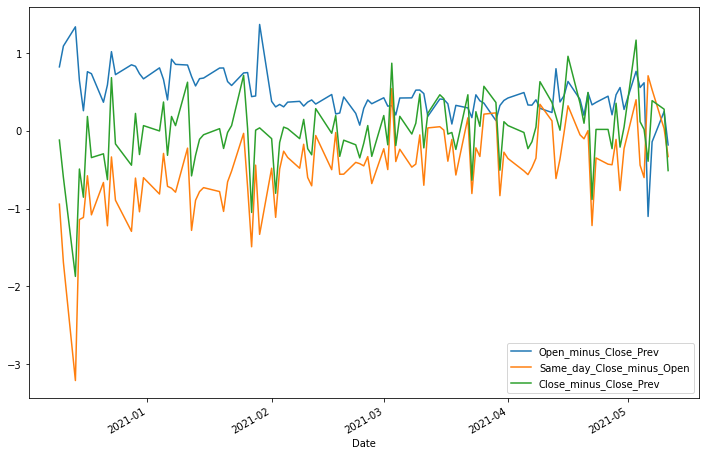

In [42]:
pfizer_df_com.plot(y=['Open_minus_Close_Prev','Same_day_Close_minus_Open','Close_minus_Close_Prev'],figsize=(12,8))

In [43]:
pfizer_df = combine_df(tweet_df, stock_pfizer, 'pfizer',[1,10,13,16])
moderna_df = combine_df(tweet_df, stock_moderna, 'moderna',[1,10,13,16])
jnj_df = combine_df(tweet_df, stock_jnj, 'johnsonandjohnson',[1,10,13,16])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

Number of UP:  55
Number of DOWN:  49
Number of UP:  51
Number of DOWN:  54
Number of UP:  57
Number of DOWN:  48


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [44]:
pfizer_df.head()

,Text,Negative,Positive,Neutral,Total Tweets,Percentage of Positive,Average Count,Score,Close_minus_Close_Prev,Close_minus_Close_Prev_3,Close_minus_Close_Prev_5,category
Date,,,,,,,,,,,,
2020-12-10,maybe this will wakeupamerica see what they ...,474,661,432,1567,0.421825,1567.000000,0.085215,-0.117546,0.470203,1.606525,DOWN
2020-12-11,the latest the med time news thanks to drc...,1102,1827,1215,4144,0.440878,1381.333333,0.130926,-0.597549,-1.410603,0.764076,DOWN
2020-12-14,everywhere there is news of vaccine and all ...,293,697,565,1555,0.448232,1555.000000,0.216682,-1.871010,-2.586105,-1.998356,DOWN
2020-12-15,why not invite only frontline health care work...,182,469,318,969,0.484004,969.000000,0.222137,-0.489796,-2.958355,-3.771408,DOWN
2020-12-16,ok pfizer this makes no sense you can ...,215,378,294,887,0.426156,887.000000,0.139894,-0.852238,-3.213043,-3.928139,DOWN


In [45]:
def preprocess(df, lag, include_text=True, verbose=False):
    lag = lag
    y_cat = df['category']
    y = df['Close_minus_Close_Prev']
    x = df.shift(periods=lag).iloc[:,:-1]
    x.drop(columns=['Negative', 'Positive', 'Neutral', 'Total Tweets'], inplace=True)
    complete_df = pd.concat([x, y, y_cat], axis=1)
    complete_df.columns = ['Text', 'Positive Ratio', 'Tweet Count', 'Sentiment Score', 'Prev_d_trend', 'Prev_3d_trend', 'Prev_5d_trend', 'Today_trend', 'Category']
    complete_df.dropna(inplace=True)
    if include_text == True:
        if verbose == True:
            print("-------------- DataFrame with text data  --------------------------")
            print(complete_df.iloc[:,:-2].info())
        return complete_df.iloc[:,:-2], complete_df.iloc[:,-1]
    else:
        numerical_df = complete_df.iloc[:,1:-1]
        if verbose == True:
            print("-------------- DataFrame with only numerical values----------------")
            print(numerical_df.info())
        return numerical_df, complete_df.iloc[:,-1]

In [46]:
# Visualization of the numerical df
def plot_trend_comparison(numerical_df):
    scalar = StandardScaler()
    x_standardized = scalar.fit_transform(numerical_df)
    # Check if there is a trend between increase in sentiment score/positive ratio with stock increase
    plt.figure(figsize=(20,5))
    plt.plot(numerical_df.index, x_standardized[:,2], label='Yesterday Sentiment Score')
    plt.plot(numerical_df.index, x_standardized[:,0], label='Yesterday Positive Ratio')
    plt.plot(numerical_df.index, x_standardized[:,6], label='Today Stock Change')
    plt.legend(loc='best')
    ax = plt.gca()
    ax.set_facecolor('white')
    plt.show()

In [47]:
pfizer_numerical_df, pfizer_y_cat = preprocess(pfizer_df, 1, include_text=False, verbose=True)
pfizer_X, pfizer_y_cat = preprocess(pfizer_df, 1, include_text=True, verbose=True)
moderna_numerical_df, moderna_y_cat = preprocess(moderna_df, 1, include_text=False)
moderna_X, moderna_y_cat = preprocess(moderna_df, 1, include_text=True)
jnj_numerical_df, jnj_y_cat = preprocess(jnj_df, 1, include_text=False)
jnj_X, jnj_y_cat = preprocess(jnj_df, 1, include_text=True)

-------------- DataFrame with only numerical values----------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104 entries, 2020-12-11 to 2021-05-11
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Positive Ratio   104 non-null    float64
 1   Tweet Count      104 non-null    float64
 2   Sentiment Score  104 non-null    float64
 3   Prev_d_trend     104 non-null    float64
 4   Prev_3d_trend    104 non-null    float64
 5   Prev_5d_trend    104 non-null    float64
 6   Today_trend      104 non-null    float64
dtypes: float64(7)
memory usage: 6.5 KB
None
-------------- DataFrame with text data  --------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104 entries, 2020-12-11 to 2021-05-11
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Text             104 non-null    object 
 1   Positive Ratio  

We also compared how the trends of increase in sentiment score/positive ratio are correlated to stock increase. The stock price wouldn't be able to instantaneously react to the current day's change of public sentiments, so that we took a lag of 1 day between the price movement and sentiment data. As we can observe that with an increase in sentiment score/positive ratio of yesterday's tweets, the today's stock price goes up. The decrease in sentiment score/positive ratio of yesterday's tweets is also correlated with the decrease in today's stock price change. We will use Pfizer as the example.

Pfizer Graph


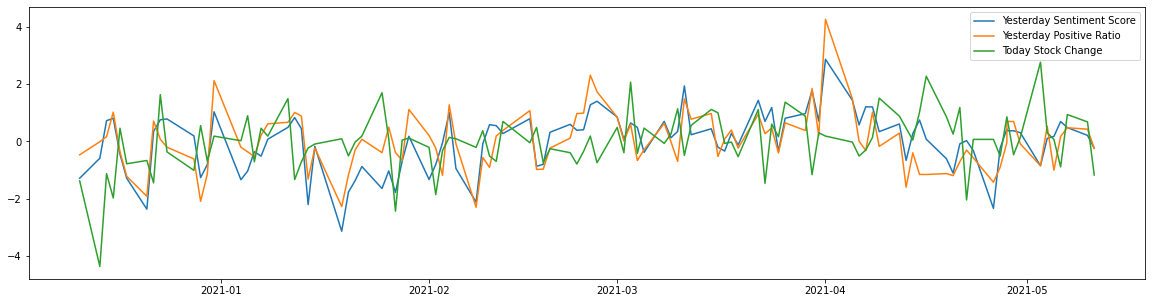

In [48]:
print("Pfizer Graph")
plot_trend_comparison(pfizer_numerical_df)
#print("Moderna Graph")
#plot_trend_comparison(moderna_numerical_df)
#print("Jnj Graph")
#plot_trend_comparison(jnj_numerical_df)

# Model Training

After data preprocessing and explotary data analysis, it time to train predictive models! Since our dataset is not large enough for models like nearal networks, we could still train data by using different models. The models we will compare here are: nonlinear classification/ Random Forest/ XGBoost.

## Nonlinear Classification 

In [49]:
def nonlinear_classification(X, y, verbose=False):
  
  kf = KFold(n_splits=5, random_state=0, shuffle=True)
  loss_choices = ['hinge', 'log']
  alpha_choices = [0.0001, 0.001, 0.01, 0.1, 1]
  max_iter_choices = [1000, 10000, 100000]

  hyperparameter_choices = [(loss, alpha, max_iter) for loss in loss_choices
                                                    for alpha in alpha_choices
                                                    for max_iter in max_iter_choices]

  best_accuracy = -np.inf
  best_hyper = None
  best_model = None
  for loss, alpha, max_iter in hyperparameter_choices:
    accuracy = []
    for train_indices, val_indices in kf.split(X):
      X_train = X.iloc[train_indices,:]
      y_train = y[train_indices]
      X_val = X.iloc[val_indices,:]
      y_val = y[val_indices]
      
      # --------- Process Training data: ----------
      # Process text columns
      X_train_text = X_train.iloc[:,0]
      corpus_train = [re.sub(r'\d+', '', text) for text in X_train_text]
      vectorizer = TfidfVectorizer(max_df=0.95,
                                  min_df=1,
                                  stop_words='english',
                                  max_features=10000)
      X_train_tokens = vectorizer.fit_transform(corpus_train)

      # Process numeric columns
      poly = PolynomialFeatures(degree=2)
      X_train_others_poly = poly.fit_transform(X_train.iloc[:,1:].to_numpy())
      
      # Combine text and numeric columns
      X_train_array = np.hstack((X_train_tokens.toarray(), X_train_others_poly))

      # -------- Process Validation data: ----------
      # Process text columns
      X_val_text = X_val.iloc[:,0]
      corpus_val = [re.sub(r'\d+', '', text) for text in X_val_text]
      X_val_tokens = vectorizer.transform(corpus_val)
      
      # Process numeric columns
      X_val_others_poly = poly.transform(X_val.iloc[:,1:].to_numpy())

      # Combine text and numeric columns
      X_val_array = np.hstack((X_val_tokens.toarray(), X_val_others_poly))

      # -------- Train Model: ------------------------
      clf = make_pipeline(StandardScaler(),
                          SGDClassifier(loss=loss, alpha=alpha, max_iter=max_iter, random_state=0))
      clf.fit(X_train_array, y_train)
      
      # --------- Predict: -----------------------------
      y_val_predict = clf.predict(X_val_array)

      # --------- Get Accuracy: -----------------------------
      accuracy.append(sum(y_val_predict == y_val)/len(y_val))

    # Cross accuracy of five fold
    cross_accuracy = np.mean(accuracy)

    if verbose:
      print('Hyperparameters: ', loss, ' ', alpha, ' ', max_iter, ' ', cross_accuracy)
    
    if cross_accuracy > best_accuracy:
      best_accuracy = cross_accuracy
      best_hyper = [loss, alpha, max_iter]
      best_model = clf

  print("Best Hyperparameters: ", best_hyper)
  print("Best Accuracy: ", best_accuracy)

  return best_model


In [50]:
print("Non-Linear Classifier")
print("Pfizer: ")
nonlinear_clf_pfizer = nonlinear_classification(pfizer_X, pfizer_y_cat)
print("Moderna: ")
nonlinear_clf_moderna = nonlinear_classification(moderna_X, moderna_y_cat)
print("Johnson & Johnson: ")
nonlinear_clf_jnj = nonlinear_classification(jnj_X, jnj_y_cat)

Non-Linear Classifier
Pfizer: 
Best Hyperparameters:  ['hinge', 1, 1000]
Best Accuracy:  0.5676190476190476
Moderna: 
Best Hyperparameters:  ['hinge', 1, 1000]
Best Accuracy:  0.49952380952380954
Johnson & Johnson: 
Best Hyperparameters:  ['hinge', 0.1, 1000]
Best Accuracy:  0.5447619047619048


## Random Forest

In [51]:
def randomforest_classification(X, y, verbose=False):

  kf = KFold(n_splits=5, random_state=0, shuffle=True)
  max_features_choices = ['auto', 'log2']
  min_samples_leaf_choices = [2,4,6,8,10,12]
  max_depth_choices = [None, 5, 6]

  hyperparameter_choices = [(max_features, min_samples_leaf, max_depth) for max_features in max_features_choices
                                                                        for min_samples_leaf in min_samples_leaf_choices
                                                                        for max_depth in max_depth_choices]

  best_accuracy = -np.inf
  best_hyper = None
  best_model = None
  for max_features, min_samples_leaf, max_depth in hyperparameter_choices:
    accuracy = []
    for train_indices, val_indices in kf.split(X):
      X_train = X.iloc[train_indices,:]
      y_train = y[train_indices]
      X_val = X.iloc[val_indices,:]
      y_val = y[val_indices]

      # --------- Process Training data: ----------
      # Process text columns
      X_train_text = X_train.iloc[:,0]
      corpus_train = [re.sub(r'\d+', '', text) for text in X_train_text]
      vectorizer = TfidfVectorizer(max_df=0.95,
                                  min_df=1,
                                  stop_words='english',
                                  max_features=10000)
      X_train_tokens = vectorizer.fit_transform(corpus_train)
      
      # Combine text and numeric columns
      X_train_array = np.hstack((X_train_tokens.toarray(), X_train.iloc[:,1:].to_numpy()))

      # -------- Process Validation data: ----------
      # Process text columns
      X_val_text = X_val.iloc[:,0]
      corpus_val = [re.sub(r'\d+', '', text) for text in X_val_text]
      X_val_tokens = vectorizer.transform(corpus_val)

      # Combine text and numeric columns
      X_val_array = np.hstack((X_val_tokens.toarray(), X_val.iloc[:,1:].to_numpy()))

      # -------- Train Model: ------------------------
      clf = make_pipeline(StandardScaler(),
                          RandomForestClassifier(max_depth=max_depth,
                                                 min_samples_leaf=min_samples_leaf,
                                                 max_features=max_features,
                                                 random_state=0))
      
      clf.fit(X_train_array, y_train)

      # --------- Predict: -----------------------------
      y_val_predict = clf.predict(X_val_array)

      # --------- Get Accuracy: -----------------------------
      accuracy.append(sum(y_val_predict == y_val)/len(y_val))

    # Cross accuracy of five fold
    cross_accuracy = np.mean(accuracy)

    if verbose:
      print('Hyperparameters: ', max_features, ' ',  min_samples_leaf, ' ', max_depth, ' ', cross_accuracy)
    
    if cross_accuracy > best_accuracy:
      best_accuracy = cross_accuracy
      best_hyper = [max_features, min_samples_leaf, max_depth]
      best_model = clf

  print("Best Hyperparameters: ", best_hyper)
  print("Best Accuracy: ", best_accuracy)

  return best_model

In [52]:
print("Random Forest Classifier")
print("Pfizer: ")
rf_clf_pfizer = randomforest_classification(pfizer_X, pfizer_y_cat)
print("Moderna: ")
rf_clf_moderna = randomforest_classification(moderna_X, moderna_y_cat)
print("Johnson & Johnson: ")
rf_clf_jnj = randomforest_classification(jnj_X, jnj_y_cat)

Random Forest Classifier
Pfizer: 
Best Hyperparameters:  ['auto', 2, 5]
Best Accuracy:  0.5661904761904762
Moderna: 
Best Hyperparameters:  ['auto', 8, None]
Best Accuracy:  0.5004761904761905
Johnson & Johnson: 
Best Hyperparameters:  ['auto', 4, 6]
Best Accuracy:  0.4542857142857143


## XGBoost

In [53]:
def xgb_classification(X, y, verbose=False):

  kf = KFold(n_splits=5, random_state=0, shuffle=True)
  colsample_bytree_choices = [0.3, 0.5, 0.7]
  n_estimators_choices = [8, 10, 12, 14]
  max_depth_choices = [3, 5, 8]

  hyperparameter_choices = [(colsample_bytree, n_estimators, max_depth) for colsample_bytree in colsample_bytree_choices
                                                                        for n_estimators in n_estimators_choices
                                                                        for max_depth in max_depth_choices]

  best_accuracy = -np.inf
  best_hyper = None
  best_model = None
  for colsample_bytree, n_estimators, max_depth in hyperparameter_choices:
    accuracy = []
    for train_indices, val_indices in kf.split(X):
      X_train = X.iloc[train_indices,:]
      y_train = y[train_indices]
      X_val = X.iloc[val_indices,:]
      y_val = y[val_indices]

      # --------- Process Training data: ----------
      # Process text columns
      X_train_text = X_train.iloc[:,0]
      corpus_train = [re.sub(r'\d+', '', text) for text in X_train_text]
      vectorizer = TfidfVectorizer(max_df=0.95,
                                  min_df=1,
                                  stop_words='english',
                                  max_features=10000)
      X_train_tokens = vectorizer.fit_transform(corpus_train)
      
      # Combine text and numeric columns
      X_train_array = np.hstack((X_train_tokens.toarray(), X_train.iloc[:,1:].to_numpy()))

      # -------- Process Validation data: ----------
      # Process text columns
      X_val_text = X_val.iloc[:,0]
      corpus_val = [re.sub(r'\d+', '', text) for text in X_val_text]
      X_val_tokens = vectorizer.transform(corpus_val)

      # Combine text and numeric columns
      X_val_array = np.hstack((X_val_tokens.toarray(), X_val.iloc[:,1:].to_numpy()))

      # -------- Train Model: ------------------------
      clf = make_pipeline(StandardScaler(),
                          xgb.XGBClassifier(objective="binary:logistic", 
                                            colsample_bytree=colsample_bytree,
                                            n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            random_state=42))
      
      clf.fit(X_train_array, y_train)

      # --------- Predict: -----------------------------
      y_val_predict = clf.predict(X_val_array)

      # --------- Get Accuracy: -----------------------------
      accuracy.append(sum(y_val_predict == y_val)/len(y_val))

    # Cross accuracy of five fold
    cross_accuracy = np.mean(accuracy)

    if verbose:
      print('Hyperparameters: ', colsample_bytree, ' ',  n_estimators, ' ', max_depth, ' ', cross_accuracy)
    
    if cross_accuracy > best_accuracy:
      best_accuracy = cross_accuracy
      best_hyper = [colsample_bytree, n_estimators, max_depth]
      best_model = clf

  print("Best Hyperparameters: ", best_hyper)
  print("Best Accuracy: ", best_accuracy)

  return best_model

In [ ]:
print("XGBoost Classifier")
print("Pfizer: ")
rf_clf_pfizer = xgb_classification(pfizer_X, pfizer_y_cat)
print("Moderna: ")
rf_clf_moderna = xgb_classification(moderna_X, moderna_y_cat)
print("Johnson & Johnson: ")
rf_clf_jnj = xgb_classification(jnj_X, jnj_y_cat)

XGBoost Classifier
Pfizer: 
Best Hyperparameters:  [0.7, 14, 5]
Best Accuracy:  0.5480952380952381
Moderna: 


# Conclusion

| Model type       | Pfizer          | Moderna         |Johnson & Johnson|
|:---------------- |:---------------:|:---------------:|:----------------|
| Nonlinear        |     0.557       |    0.500        |        0.545    |
| Random Forest    |     0.558       |    0.548        |        0.474    |
| XGBoost          |     0.529       |    0.442        |        0.534    | 

The accuracy of models we trained have been included in the table above. From the table we could tell that, even though classification accuracy among different types of models are not pretty high, these models have stable predictive accuracy around 55%. At the same time, the accuracy of Pfizer is always the highest among predictions, which is the same as what we guessed at the step of data preprocessing. We would have a better accuracy than other providers since the data size of Pfizer is also larger.

To improve the accuracy, there are some improvements that we could make:
  - If we can collect more data, the size of our training dataset would be large enough for some more complicated models such as neural nets. In this way, the accuracy of our model would be increased.
  - Tweets might be a way for us to conduct sentimental analysis. However, it might not be the best resource to do so. Instead of using twetter text, we could use financial news related to specific company to gain sentimental scores.
  - The features we considered could be extended. Except for stock price changes and sentimental analysis scores, we could also try some other factors that could influence the trend of stocks such as the vaccination rates and financial report ratings. In this way, with more factors being considered, the accuracy of our predictive model would be improved.


# Reference

[1] Qian Li, Bing Zhou and Qingzhong Liu, "Can twitter posts predict stock behavior?: A study of stock market with twitter social emotion," 2016 IEEE International Conference on Cloud Computing and Big Data Analysis (ICCCBDA), 2016, pp. 359-364, doi: 10.1109/ICCCBDA.2016.7529584.

# APPENDIX

## Twitter Scraper

Data was scrapped from Twitter api. We are interested in the recent Twitter data made about the Covid-19 vaccines, specifically by three major providers in the U.S.: Pfzier, Moderna, and Johnson&Johnson, from Dec 10, 2010 to Apr 28, 2021. Total 1,479,960 tweets are scrapped, covering 3 vaccine-related hashtags, such as “Pfzier”, “Moderna”, “J&J”, or “PfzierVac”. The language is limited to English. 

In [ ]:
class Store_Tweet:
    def __init__(self, store_raw_requests=False):
        self.attributes = ['id', 'text', 'hashtags', 'created_at']
        self._data_frame = pd.DataFrame(columns=self.attributes)
        self.file_name = "tweets_{}.csv".format(datetime.strftime(datetime.now(), '%Y-%m-%d %H:%M:%S'))

        self.store_raw_requests = store_raw_requests
        self.raw_requests_file = None
        if self.store_raw_requests:
            self.raw_requests_file = open(self.file_name + '_raw.txt', 'a+')

    def save_tweets(self, json_response):
        if self.store_raw_requests:
            self.raw_requests_file.write(json_response + "\n\n")

        processed_tweets = self.process_tweets(json_response)
        self.add_tweets_to_data(processed_tweets)

    def process_tweets(self, json_response):
        tweets = list()
        for tweet in json_response['data']:
            hashtags = " ".join(['#' + tag['tag'] for tag in tweet.get('entities', {}).get('hashtags', [])])
            processed_tweet = (tweet['id'], tweet['text'], hashtags, tweet['created_at'], tweet.get('geo', ''),
                               tweet['public_metrics']['like_count'], tweet['public_metrics']['quote_count'],
                               tweet['public_metrics']['reply_count'], tweet['public_metrics']['retweet_count'])
            tweets.append(processed_tweet)
        return tweets

    def add_tweets_to_data(self, tweets):
        new_df = pd.DataFrame(tweets, columns=self.attributes)
        self._data_frame = self._data_frame.append(new_df)

    def store(self, description=''):
        self._data_frame.index.name = 'index'
        self._data_frame.to_csv(self.file_name)
        files.download(self.file_name)

        # add description for the existing collected data
        description_file = open('description_{}.txt'.format(self.file_name), 'w+')
        description += "\n\nheaders: {}\ndata_shape: {}\nfor file: {}".format(self.attributes, self._data_frame.shape,
                                                                              self.file_name)
        description_file.write(description)
        description_file.close()

        if self.store_raw_requests:
            self.raw_requests_file.close()

In [ ]:
class Twitter_Scraper:
    def __init__(self, query, results_chunk=10, log=False, **kwargs):
        self.query = query
        self.results_chunk = results_chunk
        # other kwargs will go to the request url directly
        self._kwargs = kwargs 
        self.log = log

        self._base_url = "https://api.twitter.com/2/tweets/search/all"
        self._headers = self._create_headers(bearer_token)

        self.tweet_storage = Store_Tweet()

    def create_url(self, query, max_results=10, **kwargs):
        query = urllib.parse.quote(query)
        tweet_fields = "tweet.fields=created_at,geo,text,public_metrics"
        url = "{}?query={}&max_results={}&{}".format(self._base_url, query, max_results, tweet_fields)
        # add any more given parameters to the url's query params
        for key, value in kwargs.items():
            if value:
                url += "&{}={}".format(key, value)
        return url

    def make_request(self, url):
        if self.log:
            print('requesting', url)
        response = requests.request("GET", url, headers=self._headers)
        if self.log:
            print('The response status code: ', response.status_code)
        if response.status_code != 200:
            print('error requesting', url)
            print('the status code is', response.status_code, 'the message is', response.text)
        return response

    def _create_headers(self, bearer_token):
        headers = {"Authorization": "Bearer {}".format(bearer_token)}
        return headers

    def save_tweets(self, json_response):
        self.tweet_storage.save_tweets(json_response)

    def retrieve_pages(self, max_pages):
        page = 1
        current_page_url = self.create_url(self.query, max_results=self.results_chunk,
                                           **self._kwargs)  # the initial url containing the query
        if self.log:
            print('starting to fetch tweets, the base url is: ', current_page_url)

        last_response = None
        error_try_count = 0
        while not max_pages or max_pages is not None and page <= max_pages:
            if self.log:
                print('retrieving page', page, '...')

            response = self.make_request(current_page_url)

            # successful request
            if response.status_code == 200:  
                json_response = response.json()
                self.save_tweets(json_response)
                print('save to csv now')

                next_token = json_response['meta'].get('next_token')
                # stop if twitter has no tweets next
                if not next_token:  
                    print('no more tweets left to retrieve...')
                    break

                page += 1
                current_page_url = self.create_url(self.query, max_results=self.results_chunk, next_token=next_token,
                                                   **self._kwargs)
                error_try_count = 0
                last_response = response

                if self.log:
                    print(page * self.results_chunk, 'tweets retrieved so far')

                if page % 30 == 0:
                    self.store(response.json().get('meta'))  # checkpoint after each 30 pages

                time.sleep(1)  # to prevent the 1 sec throttling

            # handle errors for unsuccessful requests:

            # if there are too many requests
            elif response.status_code == 429:  
                self.store(last_response.json().get('meta')) 
                try:
                    print('too many requests, please try again')
                    print('the header is ', response.headers)
                    throttle_end_timestamp = int(response.headers.get('x-rate-limit-reset'))
                    throttle_end_time = datetime.strftime(datetime.fromtimestamp(throttle_end_timestamp), "%H:%M:%S")
                    time_to_wait = int(throttle_end_timestamp - datetime.now().timestamp()) + 5
                    print('sleep for', time_to_wait, 'seconds and wake up at', throttle_end_time)
                    print('sleeping ...')
                    time.sleep(time_to_wait)
                except:
                   # if the original waiting plan failed, then sleep for 3 minutes before trying again
                    print('sleep for 3 minutes and try again')
                    error_try_count += 1
                    time.sleep(60 * 3) 
                finally:
                    pass  # to prevent closing the app if it terminates in the except block for any reason e.g. manually

                continue

            else:
                print('error is unhandled , try again in 5 minutes, storing checkpoint ...')
                self.store(last_response.json().get('meta'))  # store checkpoint
                time.sleep(5 * 60)
                error_try_count += 1

                if error_try_count == 10:
                    message_from_admin = input('tried for 10 times and failed due to the error shown above, try again? y/n')
                    if message_from_admin == 'y':
                        error_try_count = 0
                    else:
                        break

                continue

    def scrape(self, max_pages=2):
        try:
            self.retrieve_pages(max_pages)
        except:
            print('program failed at some point')
        finally:
            self.store()

    def store(self, extra_description=""):
        description = "query: {} \nkwargs: {}\nextra description: {}".format(self.query, self._kwargs, extra_description)
        self.tweet_storage.store(description)

In [ ]:
query = "(#pfizer OR #moderna OR #Pfizer OR #Moderna OR #JohnsonandJohnson OR #JohnsonAndJohnson OR #PfizerVaccine) lang:en -is:retweet" 
scraper = Twitter_Scraper(query, results_chunk=500, start_time="2021-04-29T00:00:00Z",end_time="2021-05-12T00:00:00Z" )  # or any other parameters from https://developer.twitter.com/en/docs/twitter-api/tweets/search/api-reference/get-tweets-search-all
#scraper.scrape(max_pages=50000000000)  # fetch 50000000000 pages of 500 tweets 

## yfinance API

Data was scrapped from yfinance API. The API provides historical and real time stock data for companies. We sliced the stock info from Dec 10, 2010 to Apr 28, 2021, which is in step with the Twitter data we gained. Main features would be used for analysis includes: Date/ Open price/ Adj close price. More features would be created in later analysis.

In [ ]:
pip install yfinance --upgrade --no-cache-dir

In [ ]:
import yfinance as yf
import seaborn as sns
# gain stock prices data of companies

pfizer = yf.download('PFE',start="2020-12-01",end="2021-04-29")
jnj = yf.download('JNJ',start="2020-12-01",end="2021-04-29")
moderna = yf.download('MRNA',start="2020-12-01",end="2021-04-29")

# part used to reset the index so that datatime could be a column of df
pfizer.reset_index(inplace=True)
jnj.reset_index(inplace=True)
moderna.reset_index(inplace=True)

In [ ]:
# method to get the difference between today's opening price and previous closing price
def diff_prev(df, t):
  df['Previous_Close'] = df.shift(periods = t)['Adj Close']
  df['Open_minus_Close_Prev'] = df['Open'] - df['Previous_Close']
  df = df.drop('Previous_Close',axis=1)
  return df

def diff_today(df):
  df['Same_day_Close_minus_Open'] = df['Adj Close'] - df['Open']
  return df

def diff_close(df,t):
  df['Previous_Close'] = df.shift(periods = t)['Adj Close']
  df['Close_minus_Close_Prev'] = df['Adj Close'] - df['Previous_Close']
  df = df.drop('Previous_Close',axis=1)
  return df

In [ ]:
# call methods we defined to created more features 
pfizer = diff_prev(pfizer,1)
pfizer = diff_today(pfizer)
pfizer = diff_close(pfizer,1)

jnj = diff_prev(jnj,1)
jnj = diff_today(jnj)
jnj = diff_close(jnj,1)

moderna = diff_prev(moderna,1)
moderna = diff_today(moderna)
moderna = diff_close(moderna,1)

In [ ]:
jnj['Open_minus_Close_Prev_3'] = jnj['Open_minus_Close_Prev'].rolling(min_periods=1, window=3).sum()
jnj['Same_day_Close_minus_Open_3'] = jnj['Same_day_Close_minus_Open'].rolling(min_periods=1, window=3).sum()
jnj['Close_minus_Close_Prev_3'] = jnj['Close_minus_Close_Prev'].rolling(min_periods=1, window=3).sum()
jnj['Open_minus_Close_Prev_5'] = jnj['Open_minus_Close_Prev'].rolling(min_periods=1, window=5).sum()
jnj['Same_day_Close_minus_Open_5'] = jnj['Same_day_Close_minus_Open'].rolling(min_periods=1, window=5).sum()
jnj['Close_minus_Close_Prev_5'] = jnj['Close_minus_Close_Prev'].rolling(min_periods=1, window=5).sum()

pfizer['Open_minus_Close_Prev_3'] = pfizer['Open_minus_Close_Prev'].rolling(min_periods=1, window=3).sum()
pfizer['Same_day_Close_minus_Open_3'] = pfizer['Same_day_Close_minus_Open'].rolling(min_periods=1, window=3).sum()
pfizer['Close_minus_Close_Prev_3'] = pfizer['Close_minus_Close_Prev'].rolling(min_periods=1, window=3).sum()
pfizer['Open_minus_Close_Prev_5'] = pfizer['Open_minus_Close_Prev'].rolling(min_periods=1, window=5).sum()
pfizer['Same_day_Close_minus_Open_5'] = pfizer['Same_day_Close_minus_Open'].rolling(min_periods=1, window=5).sum()
pfizer['Close_minus_Close_Prev_5'] = pfizer['Close_minus_Close_Prev'].rolling(min_periods=1, window=5).sum()

moderna['Open_minus_Close_Prev_3'] = moderna['Open_minus_Close_Prev'].rolling(min_periods=1, window=3).sum()
moderna['Same_day_Close_minus_Open_3'] = moderna['Same_day_Close_minus_Open'].rolling(min_periods=1, window=3).sum()
moderna['Close_minus_Close_Prev_3'] = moderna['Close_minus_Close_Prev'].rolling(min_periods=1, window=3).sum()
moderna['Open_minus_Close_Prev_5'] = moderna['Open_minus_Close_Prev'].rolling(min_periods=1, window=5).sum()
moderna['Same_day_Close_minus_Open_5'] = moderna['Same_day_Close_minus_Open'].rolling(min_periods=1, window=5).sum()
moderna['Close_minus_Close_Prev_5'] = moderna['Close_minus_Close_Prev'].rolling(min_periods=1, window=5).sum()

In [ ]:
# drop extra rows
jnj = jnj.iloc[7:]
pfizer = pfizer.iloc[7:]
moderna = moderna.iloc[7:]

# save dataframes as csv files
jnj.to_csv(r'val_jnj.csv', index = True)
pfizer.to_csv(r'val_pfizer.csv', index = True)
moderna.to_csv(r'val_moderna.csv', index = True)